<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarc.csv.gz
test-unbalanced.csv  train-balanced-sarcasm.csv


In [2]:
!pip3 install --upgrade scipy
!pip3 install wordcloud plotly

import os
import string  

import scipy
import numpy as np
import pandas as pd

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

import plotly
plotly.offline.init_notebook_mode()

from plotly import graph_objs as go
from plotly import tools

import eli5

    100% |████████████████████████████████| 25.9MB 1.6MB/s 
kmodes 0.9 has requirement scikit-learn<0.20.0,>=0.19.0, but you'll have scikit-learn 0.20.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.16.0 which is incompatible.
kmeans-smote 0.1.0 has requirement scikit-learn<0.20,>=0.19.0, but you'll have scikit-learn 0.20.2 which is incompatible.
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
You are using pip version 18.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

label                        ...                                                             parent_comment
0      0                        ...                          Yeah, I get that argument. At this point, I'd ...
1      0                        ...                          The blazers and Mavericks (The wests 5 and 6 s...
2      0                        ...                                                    They're favored to win.
3      0                        ...                                                 deadass don't kill my buzz
4      0                        ...                          Yep can confirm I saw the tool they use for th...

[5 rows x 10 columns]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

### Word Cloud:

Look at the frequently occuring words in the data by creating a word cloud on the 'comment' column.

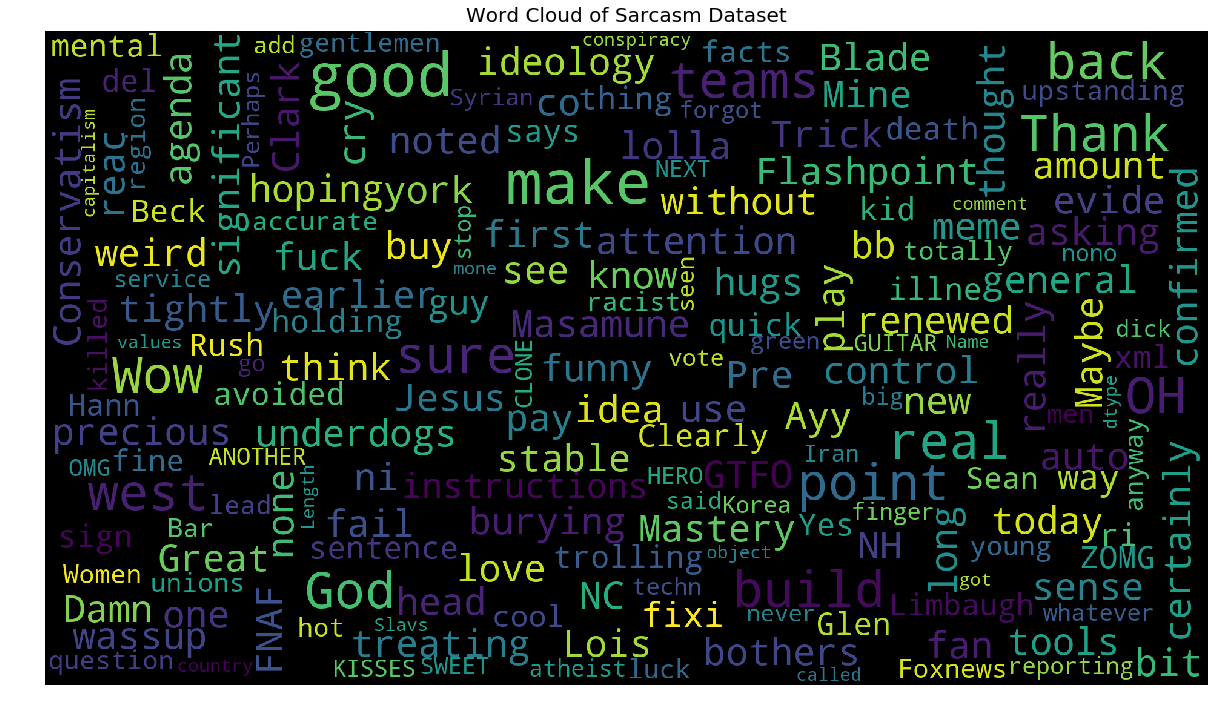

In [8]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(18.0, 10.0), 
                   title = None, title_size=20, image_color=False):
    
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=1920, 
                    height=1080,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df['comment'], title='Word Cloud of Sarcasm Dataset')

In [9]:
train_df_pos = train_df[train_df['label']==1]
train_df_neg = train_df[train_df['label']==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df['word'].values[::-1],
        x=df['wordcount'].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from statements with sarcasm ##
freq_dict = defaultdict(int)
for sent in train_df_pos['comment']:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ['word', 'wordcount']

trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from statements without sarcasm ##
freq_dict = defaultdict(int)

for sent in train_df_neg['comment']:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ['word', 'wordcount']
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=['Frequent words of statements with sarcasm', 
                                          'Frequent words of statements without sarcasm'])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title='Word Count Plots')

plotly.offline.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [10]:
freq_dict = defaultdict(int)

for sent in train_df_pos['comment']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ['word', 'wordcount']
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'yellow')


freq_dict = defaultdict(int)

for sent in train_df_neg['comment']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ['word', 'wordcount']
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'yellow')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=['Frequent bigrams of statements with sarcasm', 
                                          'Frequent bigrams of statements without sarcasm'])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")

plotly.offline.iplot(fig, filename='bigram-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [11]:
freq_dict = defaultdict(int)

for sent in train_df_pos['comment']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ['word', 'wordcount']
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)

for sent in train_df_neg['comment']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ['word', 'wordcount']
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=['Frequent trigrams of statements with sarcasm', 
                                          'Frequent trigrams of statements without sarcasm'])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")

plotly.offline.iplot(fig, filename='trigram-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



## **Feature Engineering:**

Now let us create some additional features and then look at how they are distributed between the labels:

- Number of words in the text
- Number of unique words in the text
- Number of characters in the text
- Number of stopwords
- Number of punctuations
- Number of upper case words
- Number of title case words
- Average length of the words



In [12]:
# Number of words in the text
train_df['num_words'] = train_df['comment'].apply(lambda x: len(str(x).split()))

# Number of unique words in the text 
train_df['num_unique_words'] = train_df['comment'].apply(lambda x: len(set(str(x).split())))

# Number of characters in the text 
train_df['num_chars'] = train_df['comment'].apply(lambda x: len(str(x)))

# Number of stopwords in the text 
train_df['num_stopwords'] = train_df['comment'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# Number of punctuations in the text
train_df['num_punctuations'] = train_df['comment'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# Number of title case words in the text
train_df['num_words_upper'] = train_df['comment'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the text 
train_df['num_words_title'] = train_df['comment'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words in the text 
train_df['mean_word_len'] = train_df['comment'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [13]:
train_df.head()

label      ...      mean_word_len
0      0      ...           2.666667
1      0      ...           4.357143
2      0      ...           5.421053
3      0      ...           4.083333
4      0      ...           3.571429

[5 rows x 18 columns]

Plot how these generated features are distributed between both sarcastic and unsarcastic comments

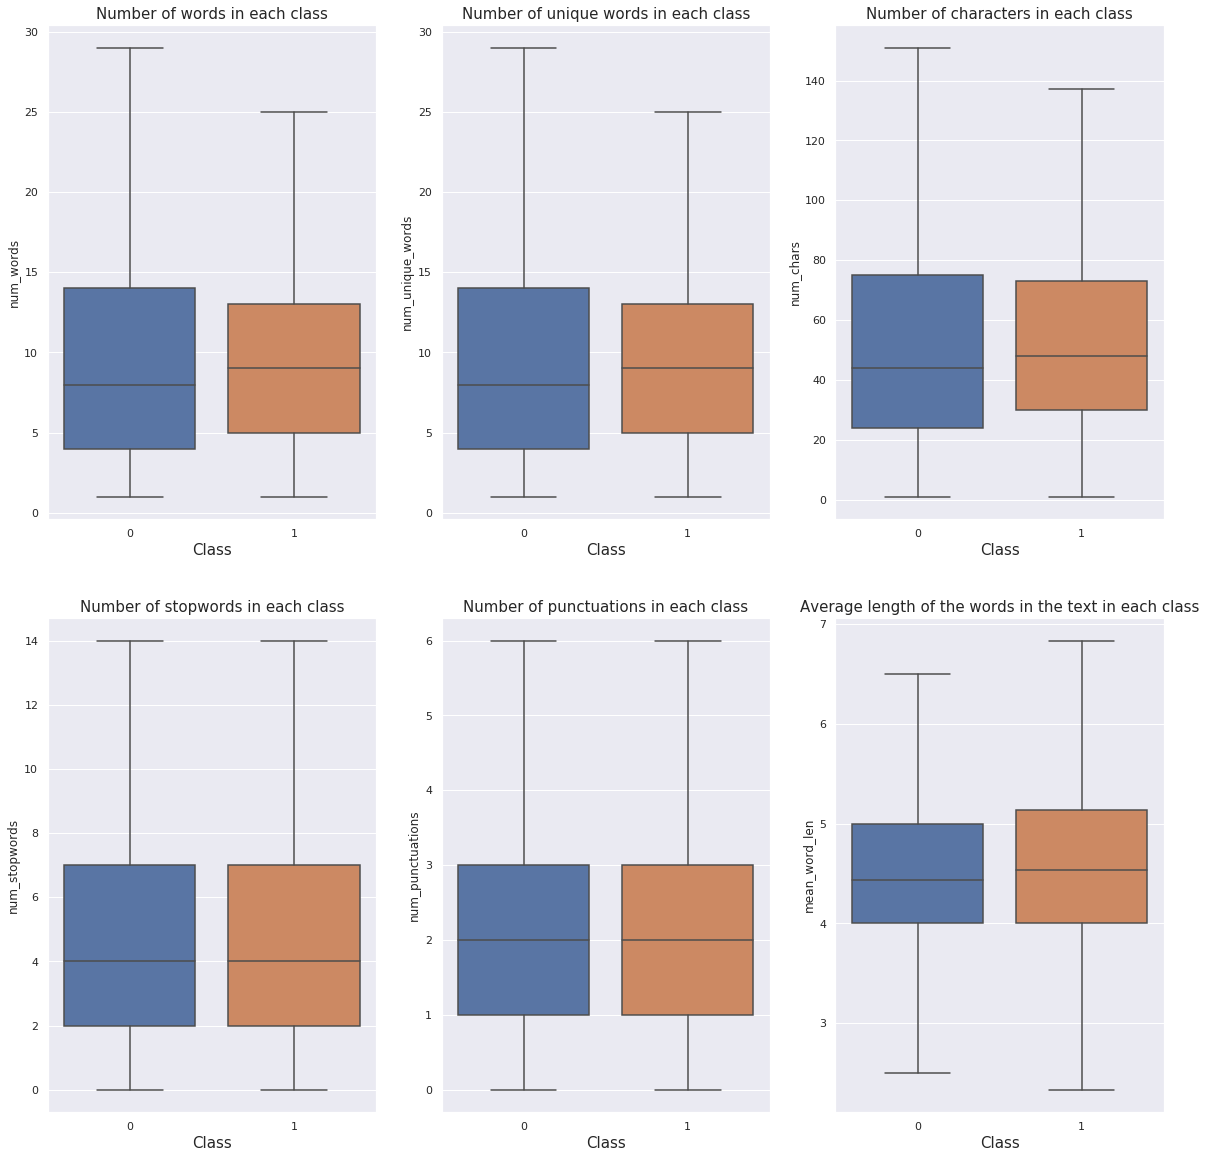

In [14]:
f, axes = plt.subplots(2, 3, figsize=(20,20))

sns.boxplot(x='label',y='num_words', data=train_df, ax=axes[0][0], showfliers=False)
sns.boxplot(x='label',y='num_unique_words', data=train_df, ax=axes[0][1], showfliers=False)
sns.boxplot(x='label', y='num_chars', data=train_df, ax=axes[0][2], showfliers=False)
sns.boxplot(x='label', y='num_stopwords', data=train_df, ax=axes[1][0], showfliers=False)
sns.boxplot(x='label', y='num_punctuations', data=train_df, ax=axes[1][1], showfliers=False)
sns.boxplot(x='label', y='mean_word_len', data=train_df, ax=axes[1][2], showfliers=False)


axes[0][0].set_xlabel('Class', fontsize=15)
axes[0][0].set_title("Number of words in each class", fontsize=15)

axes[0][1].set_xlabel('Class', fontsize=15)
axes[0][1].set_title("Number of unique words in each class", fontsize=15)

axes[0][2].set_xlabel('Class', fontsize=15)
axes[0][2].set_title("Number of characters in each class", fontsize=15)

axes[1][0].set_xlabel('Class', fontsize=15)
axes[1][0].set_title("Number of stopwords in each class", fontsize=15)

axes[1][1].set_xlabel('Class', fontsize=15)
axes[1][1].set_title("Number of punctuations in each class", fontsize=15)

axes[1][2].set_xlabel('Class', fontsize=15)
axes[1][2].set_title("Average length of the words in the text in each class", fontsize=15)

plt.show()

We can see that generated features are almost uselss in future classifier for linearly separating two target classes

Correlation matrix of numeric features

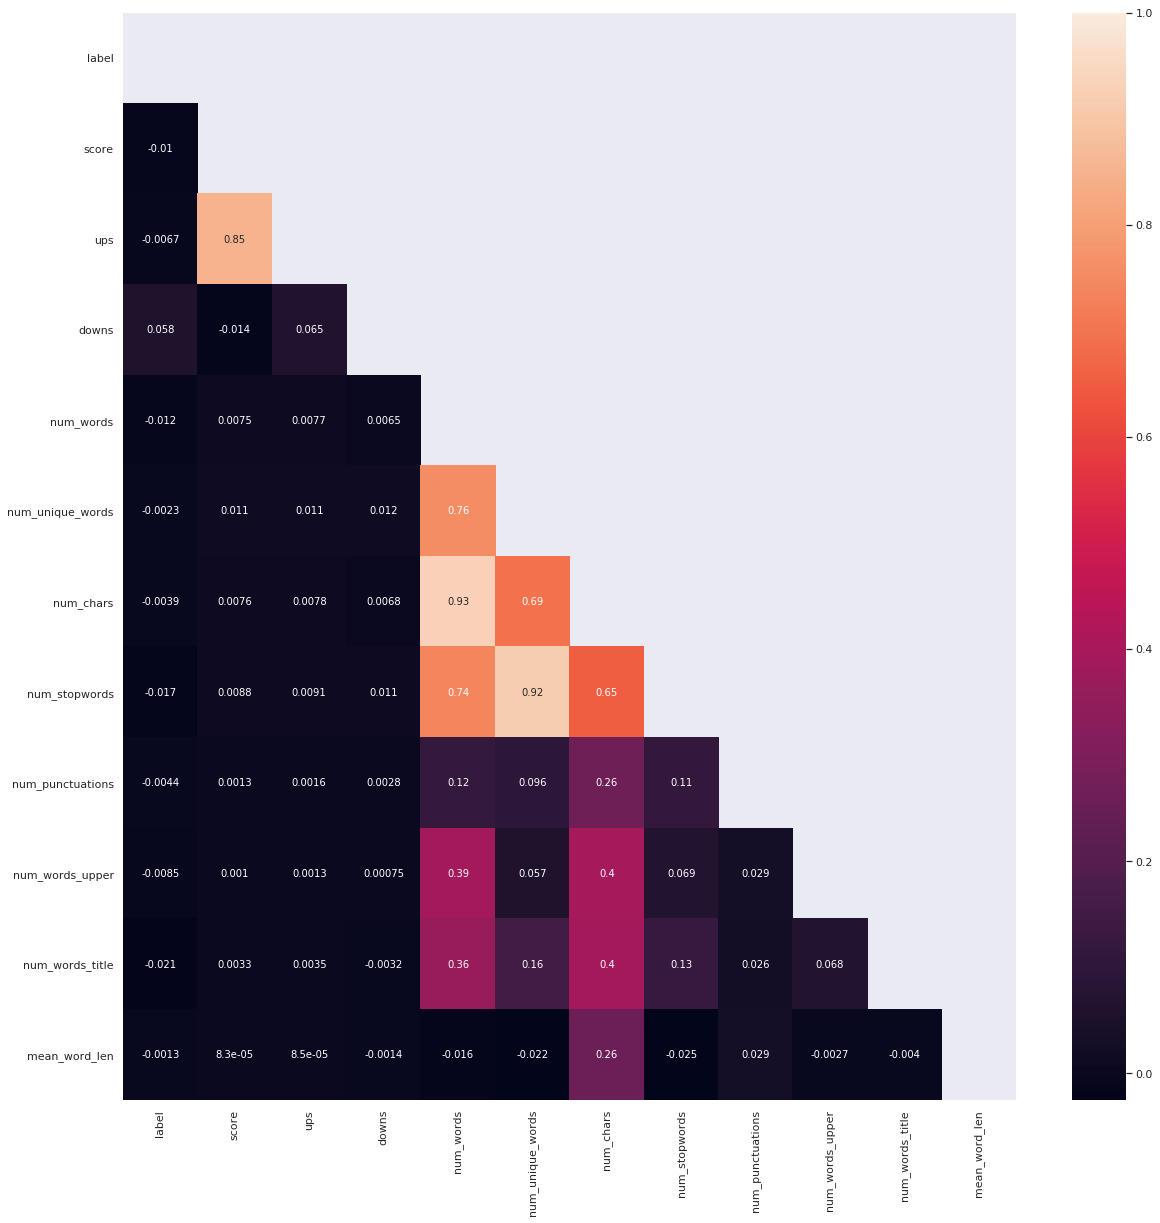

In [15]:
plt.figure(figsize=(20,20))

corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, mask=mask)
plt.show()

Next, we split data into training and validation parts.

In [16]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'], train_df['label'], test_size=0.2, random_state=41)

### **Baseline Model:**

To start with, let us just build a baseline model (Logistic Regression) with TFIDF vectors.

In [17]:
%%time

# Get the tfidf vectors

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)

train_tfidf = tfidf_vec.fit_transform(train_texts)
test_tfidf = tfidf_vec.transform(valid_texts)

CPU times: user 36.9 s, sys: 1.2 s, total: 38.1 s
Wall time: 38.1 s


In [18]:
%%time

C_s = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1, 3, 5, 7, 10]
predictions = []
models = []

for C_reg in C_s:
    print(f'Build model for C: {C_reg}')
    
    model = LogisticRegression(penalty='l2', C=C_reg, solver='sag', random_state=41)
    model.fit(train_tfidf, y_train)
    models.append(model)

    pred_test_y = model.predict_proba(test_tfidf)[:,1]
    predictions.append(pred_test_y)

Build model for C: 0.001
Build model for C: 0.01
Build model for C: 0.1
Build model for C: 0.3
Build model for C: 0.5
Build model for C: 0.8
Build model for C: 1
Build model for C: 3
Build model for C: 5
Build model for C: 7
Build model for C: 10
CPU times: user 3min 52s, sys: 67 ms, total: 3min 52s
Wall time: 3min 53s


In [19]:
len(predictions)

11

In [20]:
for index, pred in enumerate(predictions):
    
    max_score = 0
    best_thresh = 0
    
    for thresh in np.arange(0.4, 0.7, 0.005):
        
        thresh = np.round(thresh, 2)
        score = accuracy_score(y_valid, (pred>thresh).astype(int))
        
        if score > max_score:
            max_score = score
            best_thresh = thresh
    
    print(f'C reg = {C_s[index]}, best acc_score = {max_score}, best threshold = {best_thresh}')

C reg = 0.001, best acc_score = 0.6572036308772972, best threshold = 0.5
C reg = 0.01, best acc_score = 0.6844154238084638, best threshold = 0.49
C reg = 0.1, best acc_score = 0.7137790309416042, best threshold = 0.49
C reg = 0.3, best acc_score = 0.7207885038707922, best threshold = 0.49
C reg = 0.5, best acc_score = 0.7227078232049665, best threshold = 0.5
C reg = 0.8, best acc_score = 0.7226929831070218, best threshold = 0.51
C reg = 1, best acc_score = 0.7224951151344265, best threshold = 0.51
C reg = 3, best acc_score = 0.7195073087482378, best threshold = 0.52
C reg = 5, best acc_score = 0.7181469664366451, best threshold = 0.52
C reg = 7, best acc_score = 0.7168558779154609, best threshold = 0.52
C reg = 10, best acc_score = 0.7160297791298756, best threshold = 0.51


In [21]:
y_pred = (predictions[4] > 0.5).astype(int)

In [22]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73    101151
           1       0.74      0.68      0.71    101004

   micro avg       0.72      0.72      0.72    202155
   macro avg       0.72      0.72      0.72    202155
weighted avg       0.72      0.72      0.72    202155



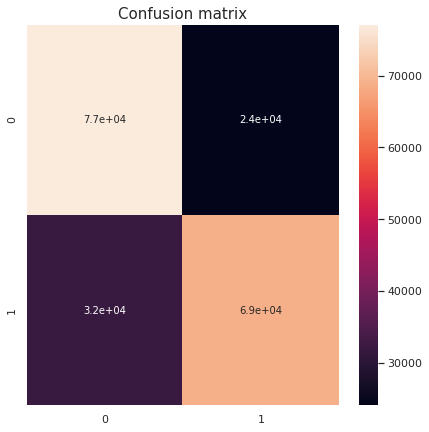

In [23]:
plt.figure(figsize=(7, 7))
cm = confusion_matrix(y_valid, y_pred)
plt.title('Confusion matrix', fontsize=15)
sns.heatmap(cm, annot=True)
plt.show()

In [24]:
eli5.show_weights(models[4], vec=tfidf_vec, top=50, feature_filter=lambda x: x != '<BIAS>')

### **Improved Model with Subreddits data:**


In [25]:
subreddits = train_df['subreddit']
subreddits.head()

0              politics
1                   nba
2                   nfl
3    BlackPeopleTwitter
4    MaddenUltimateTeam
Name: subreddit, dtype: object

In [26]:
train_subreddits, test_subreddits = train_test_split(subreddits, test_size=0.2, random_state=41)

In [27]:
%%time

subred_vec = TfidfVectorizer()

train_subreddits = subred_vec.fit_transform(train_subreddits)
test_subreddits = subred_vec.transform(test_subreddits)

CPU times: user 3.53 s, sys: 12 ms, total: 3.54 s
Wall time: 3.55 s


In [28]:
X_train = scipy.sparse.hstack([train_tfidf, train_subreddits])
X_valid = scipy.sparse.hstack([test_tfidf, test_subreddits])

In [29]:
X_train.shape, X_valid.shape

((808618, 63580), (202155, 63580))

In [30]:
%%time

C_s = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1, 3, 5, 7, 10]
predictions = []
models = []

for C_reg in C_s:
    print(f'Build model for C: {C_reg}')
    
    model = LogisticRegression(penalty='l2', C=C_reg, solver='sag', random_state=41)
    model.fit(X_train, y_train)
    models.append(model)

    pred_test_y = model.predict_proba(X_valid)[:,1]
    predictions.append(pred_test_y)

Build model for C: 0.001
Build model for C: 0.01
Build model for C: 0.1
Build model for C: 0.3
Build model for C: 0.5
Build model for C: 0.8
Build model for C: 1
Build model for C: 3
Build model for C: 5
Build model for C: 7
Build model for C: 10
CPU times: user 4min 53s, sys: 800 ms, total: 4min 54s
Wall time: 4min 54s


In [31]:
for index, pred in enumerate(predictions):
    
    max_score = 0
    best_thresh = 0
    
    for thresh in np.arange(0.4, 0.7, 0.005):
        
        thresh = np.round(thresh, 2)
        score = accuracy_score(y_valid, (pred>thresh).astype(int))
        
        if score > max_score:
            max_score = score
            best_thresh = thresh
    
    print(f'C reg = {C_s[index]}, best acc_score = {max_score}, best threshold = {best_thresh}')

C reg = 0.001, best acc_score = 0.6404244268012169, best threshold = 0.49
C reg = 0.01, best acc_score = 0.6823823303900473, best threshold = 0.5
C reg = 0.1, best acc_score = 0.7174247483366724, best threshold = 0.5
C reg = 0.3, best acc_score = 0.7254730281219856, best threshold = 0.49
C reg = 0.5, best acc_score = 0.7266998095520764, best threshold = 0.5
C reg = 0.8, best acc_score = 0.7270015582102842, best threshold = 0.5
C reg = 1, best acc_score = 0.7268333704335782, best threshold = 0.5
C reg = 3, best acc_score = 0.7240632188172442, best threshold = 0.5
C reg = 5, best acc_score = 0.7221686329796443, best threshold = 0.49
C reg = 7, best acc_score = 0.720966585046128, best threshold = 0.51
C reg = 10, best acc_score = 0.7198783111968539, best threshold = 0.51


In [32]:
y_pred = (predictions[5] > 0.52).astype(int)

In [33]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74    101151
           1       0.75      0.67      0.71    101004

   micro avg       0.73      0.73      0.73    202155
   macro avg       0.73      0.73      0.73    202155
weighted avg       0.73      0.73      0.73    202155



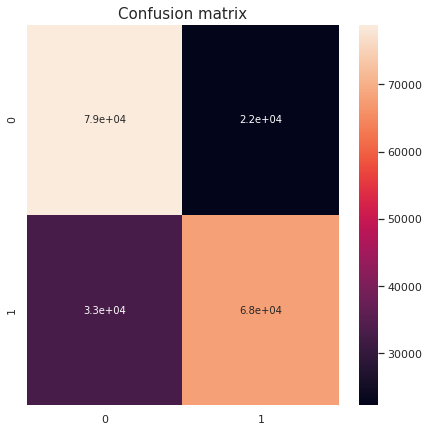

In [34]:
plt.figure(figsize=(7, 7))
cm = confusion_matrix(y_valid, y_pred)
plt.title('Confusion matrix', fontsize=15)
sns.heatmap(cm, annot=True)
plt.show()

In [35]:
eli5.show_weights(models[5], vec=tfidf_vec, top=50, feature_filter=lambda x: x != '<BIAS>')